In [2]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import sklearn.datasets as dt
import seaborn as sns         
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import cv2

"""
PIL pixel formats:

RGB 24bits per pixel, 8-bit-per-channel RGB), 3 channels
RGBA (8-bit-per-channel RGBA), 4 channels
RGBa (8-bit-per-channel RGBA, remultiplied alpha), 4 channels
1 - 1bpp, often for masks, 1 channel
L - 8bpp, grayscale, 1 channel
P - 8bpp, paletted, 1 channel
I - 32-bit integers, grayscale, 1 channel
F - 32-bit floats, grayscale, 1 channel
CMYK - 8 bits per channel, 4 channels
YCbCr - 8 bits per channel, 3 channels
"""

'\nPIL pixel formats:\n\nRGB 24bits per pixel, 8-bit-per-channel RGB), 3 channels\nRGBA (8-bit-per-channel RGBA), 4 channels\nRGBa (8-bit-per-channel RGBA, remultiplied alpha), 4 channels\n1 - 1bpp, often for masks, 1 channel\nL - 8bpp, grayscale, 1 channel\nP - 8bpp, paletted, 1 channel\nI - 32-bit integers, grayscale, 1 channel\nF - 32-bit floats, grayscale, 1 channel\nCMYK - 8 bits per channel, 4 channels\nYCbCr - 8 bits per channel, 3 channels\n'

In [3]:
filelist = glob.glob('data_generated/*.png')
x = []
for fname in filelist:
    im = cv2.imread(fname, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Binarization
    ret, th = cv2.threshold(blurred,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    x.append(th)

x = np.array(x)

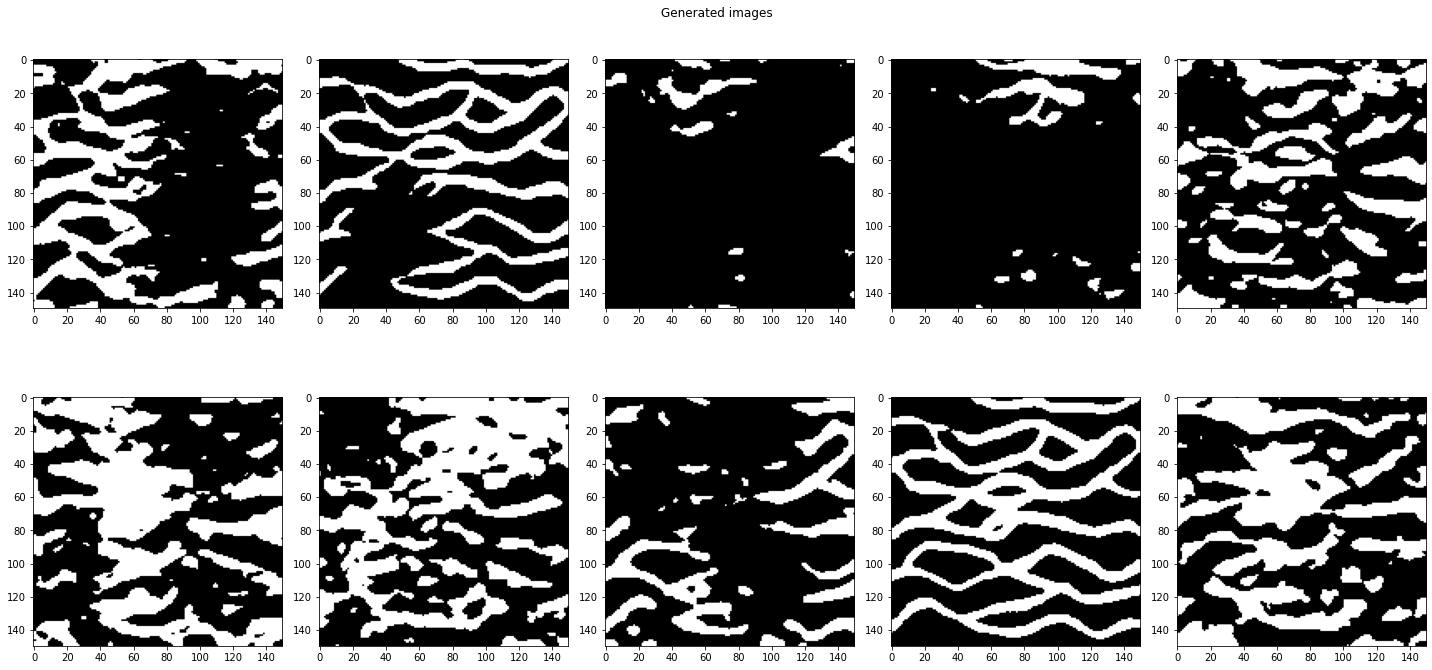

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=False, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.
    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    #assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        #list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    plt.suptitle("Generated images")
    _ = plt.show()


show_image_list(x[30:40], list_cmaps=['gray']*10, num_cols=5)

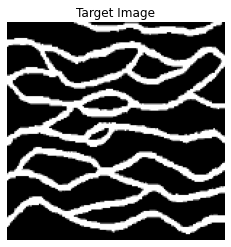

In [9]:
from skimage.transform import resize

filelist_target = glob.glob('TI/*.png')
im = cv2.imread(r'C:\Users\Gustavo Scholze\gan-for-mps\TI\strebelle.png', cv2.COLOR_BGR2GRAY)

# Binarization
ret, target_img = cv2.threshold(im,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Resize image
target_img = resize(target_img, (150,150))

plt.imshow(target_img, cmap='gray')
plt.title('Target Image')
plt.axis('off')
plt.show()

# Structural similarity

In [10]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

mse_none = [mean_squared_error(im, target_img) for im in x]
ssim_none = [ssim(im, target_img, data_range=im.max()-im.min()) for im in x]

In [32]:
similar = ssim_none.copy()
similar.sort(reverse=True)
top_10_images = similar[:10]
bottom_10_images = similar[len(similar)-10:len(similar)]

[0.22948147158958465,
 0.22925681379778556,
 0.22770215307579142,
 0.2272945933952077,
 0.2260058682969845,
 0.2126750981272149,
 0.2056503793700071,
 0.20424001569278963,
 0.2007836399926497,
 0.16814915451429724]

In [5]:
from sklearn import manifold

x = x.reshape(x.shape[0], -1)
#y= np.array([-1,1,1])

mds = manifold.MDS(max_iter=3000, dissimilarity="precomputed", n_jobs=1)

coords = mds.fit(x).embedding_

plt.scatter(coords[:, 0], coords[:, 1], marker='x', s=50, edgecolor='None')
plt.tight_layout()

ValueError: array must be 2-dimensional and square. shape = (197, 22500)